# Build ResNet50

In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


In [2]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [3]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides = (1,1), padding = 'same',name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [4]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), padding='same', name ='avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

# Load CIFAR-10 Data

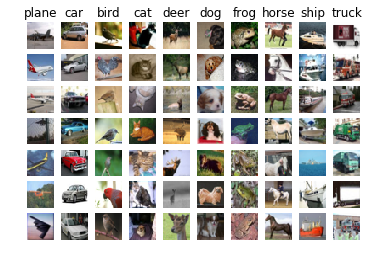

Train data shape:(9794, 32, 32, 3),
Train labels shape:(9794,), 
Validation data shape:(206, 32, 32, 3),
Validation labels shape:(206,),
Test data shape:(2000, 32, 32, 3),
Test labels shape:(2000,),


In [5]:
import matplotlib.pyplot as plt
import os
def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'r') as f:
    datadict = pickle.load(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte
from algorithms.data_utils import load_CIFAR10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_CIFAR10_data(num_training=49000, num_val=1000, num_test=10000, show_sample=True):
    """
    Load the CIFAR-10 dataset, and divide the sample into training set, validation set and test set
    """

    cifar10_dir = 'cifar-10-batches-py/'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # subsample the data for validation set
    mask = range(num_training, num_training + num_val)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    return X_train, y_train, X_val, y_val, X_test, y_test

def subset_classes_data(classes):
    # Subset 'plane' and 'car' classes to perform logistic regression
    idxs = np.logical_or(y_train_raw == 0, y_train_raw == 1)
    X_train = X_train_raw[idxs, :]
    y_train = y_train_raw[idxs]
    # validation set
    idxs = np.logical_or(y_val_raw == 0, y_val_raw == 1)
    X_val = X_val_raw[idxs, :]
    y_val = y_val_raw[idxs]
    # test set
    idxs = np.logical_or(y_test_raw == 0, y_test_raw == 1)
    X_test = X_test_raw[idxs, :]
    y_test = y_test_raw[idxs]
    return X_train, y_train, X_val, y_val, X_test, y_test

def visualize_sample(X_train, y_train, classes, samples_per_class=7):
    """visualize some samples in the training datasets """
    num_classes = len(classes)
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y) # get all the indexes of cls
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs): # plot the image one by one
            plt_idx = i * num_classes + y + 1 # i*num_classes and y+1 determine the row and column respectively
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
    
def preprocessing_CIFAR10_data(X_train, y_train, X_val, y_val, X_test, y_test):
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1)) # [49000, 3072]
    X_val = np.reshape(X_val, (X_val.shape[0], -1)) # [1000, 3072]
    X_test = np.reshape(X_test, (X_test.shape[0], -1)) # [10000, 3072]
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    
    # Add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T
    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above functions to get our data
X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw = get_CIFAR10_data()
visualize_sample(X_train_raw, y_train_raw, classes)
subset_classes = ['plane', 'cat']
X_train, y_train, X_val, y_val, X_test, y_test = subset_classes_data(subset_classes)
# As a sanity check, we print out th size of the training and test data dimenstion
print ("Train data shape:{},".format(X_train.shape))
print ("Train labels shape:{}, ".format(y_train.shape))
print ("Validation data shape:{},".format(X_val.shape))
print ("Validation labels shape:{},".format(y_val.shape))
print ("Test data shape:{},".format(X_test.shape))
print ("Test labels shape:{},".format(y_test.shape))

In [6]:
model = ResNet50(input_shape = (32, 32, 3), classes = 2)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
# Normalize image vectors
X_train = X_train/255.
X_test = X_test/255.

# Convert training and test labels to one hot matrices
y_train = convert_to_one_hot(y_train, 2).T
y_test = convert_to_one_hot(y_test, 2).T

# Train the Neural Net

In [20]:
model.fit(X_train, y_train, epochs = 2, batch_size = 512)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
9794/9794 [==============================] - 400s 41ms/step - loss: 1.3216 - acc: 0.6528
Epoch 2/2
9794/9794 [==============================] - 382s 39ms/step - loss: 0.5312 - acc: 0.7832


# Experiments - Convergence

In [16]:
def data_replication(X,y,r):
    if r==1:
        return X,y
    idx = np.random.choice(X.shape[0], int(X.shape[0]/r),replace=False)
    X = np.tile(X[idx,:], (r,1,1,1))
    y =np.tile(y[idx], (r,1))
    return X,y



In [ ]:
loss_mtx=[]
for epochs in range(1,9):
    loss=[]
    for r in [1,2,4,8]:
        X_train_r,y_train_r = data_replication(X_train,y_train,r)
        print("epochs={}".format(epochs))
        print("Data Replication Factor = {}".format(r))
        print(X_train_r.shape)
        print(y_train_r.shape)
        model = ResNet50(input_shape = (32, 32, 3), classes = 2)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(X_train_r, y_train_r, epochs = epochs, batch_size = 16)
        loss.append(np.average(history.history['loss']))
        plt.plot(history.history['loss'])
    loss_mtx.append(loss.copy())

epochs=1
Data Replication Factor = 1
(9794, 32, 32, 3)
(9794, 2)
Epoch 1/1
9794/9794 [==============================] - 458s 47ms/step - loss: 0.9074 - acc: 0.7422
epochs=1
Data Replication Factor = 2
(9794, 32, 32, 3)
(9794, 2)
Epoch 1/1
9794/9794 [==============================] - 2681s 274ms/step - loss: 1.1922 - acc: 0.7527
epochs=1
Data Replication Factor = 4
(9792, 32, 32, 3)
(9792, 2)
Epoch 1/1
9792/9792 [==============================] - 574s 59ms/step - loss: 0.9423 - acc: 0.7740
epochs=1
Data Replication Factor = 8
(9792, 32, 32, 3)
(9792, 2)
Epoch 1/1
9792/9792 [==============================] - 859s 88ms/step - loss: 1.0264 - acc: 0.7500
epochs=2
Data Replication Factor = 1
(9794, 32, 32, 3)
(9794, 2)
Epoch 1/2
9794/9794 [==============================] - 948s 97ms/step - loss: 0.7734 - acc: 0.7359
Epoch 2/2
9794/9794 [==============================] - 1111s 113ms/step - loss: 0.4529 - acc: 0.8200
epochs=2
Data Replication Factor = 2
(9794, 32, 32, 3)
(9794, 2)
Epoch 1/2
97

9794/9794 [==============================] - 787s 80ms/step - loss: 0.8409 - acc: 0.7940
Epoch 3/6
9794/9794 [==============================] - 805s 82ms/step - loss: 0.8941 - acc: 0.6815
Epoch 4/6
9794/9794 [==============================] - 784s 80ms/step - loss: 0.6990 - acc: 0.7558
Epoch 5/6
9794/9794 [==============================] - 797s 81ms/step - loss: 0.6300 - acc: 0.7673
Epoch 6/6
9794/9794 [==============================] - 808s 83ms/step - loss: 0.5588 - acc: 0.7825
epochs=6
Data Replication Factor = 4
(9792, 32, 32, 3)
(9792, 2)
Epoch 1/6
9792/9792 [==============================] - 919s 94ms/step - loss: 0.9063 - acc: 0.7676
Epoch 2/6
9792/9792 [==============================] - 777s 79ms/step - loss: 0.5961 - acc: 0.8618
Epoch 3/6
9792/9792 [==============================] - 777s 79ms/step - loss: 0.5867 - acc: 0.8778
Epoch 4/6
9792/9792 [==============================] - 783s 80ms/step - loss: 0.4824 - acc: 0.8879
Epoch 5/6
9792/9792 [==============================] -

In [17]:
X_train_r,y_train_r=data_replication(X_train,y_train,4)

In [18]:
y_train.shape

(9794, 2)